## 🤖 Caso práctico: Verificador de información (Agentic RAG) con `LangGraph`

#### 📝 **Tarea**

Crear un Agente basado en arquitectura RAG utilizando LangGraph. El agente se encargará de verificar la información preguntada por el usuario, ya que dispone de una base de datos privada con "verdades", y corroborar que dice internet.

#### 📚 **Qué aprenderemos**

- Configuración de Langgraph para crear estructuras de grafos.
- Arquitectura básica de un RAG, buscando en varias bases de datos y generando flujos de razonamiento inteligentes
- Diseño de los diferentes prompts adecuados a cada tarea
- Gestión y creación de bases de datos vectoriales

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/"

clase2_financial_data.json		Tema10_Clase1_AmazonSales.ipynb
fake_news_corpus_spanish.csv		Tema10_Clase2_FinancialLLM.ipynb
fake_news_corpus_spanish_title.parquet	Tema10_Clase3_AgenteVerificacion.ipynb


### 🔩 0. Setup

Seguir los pasos de la siguiente imagen para setear las variables de entorno

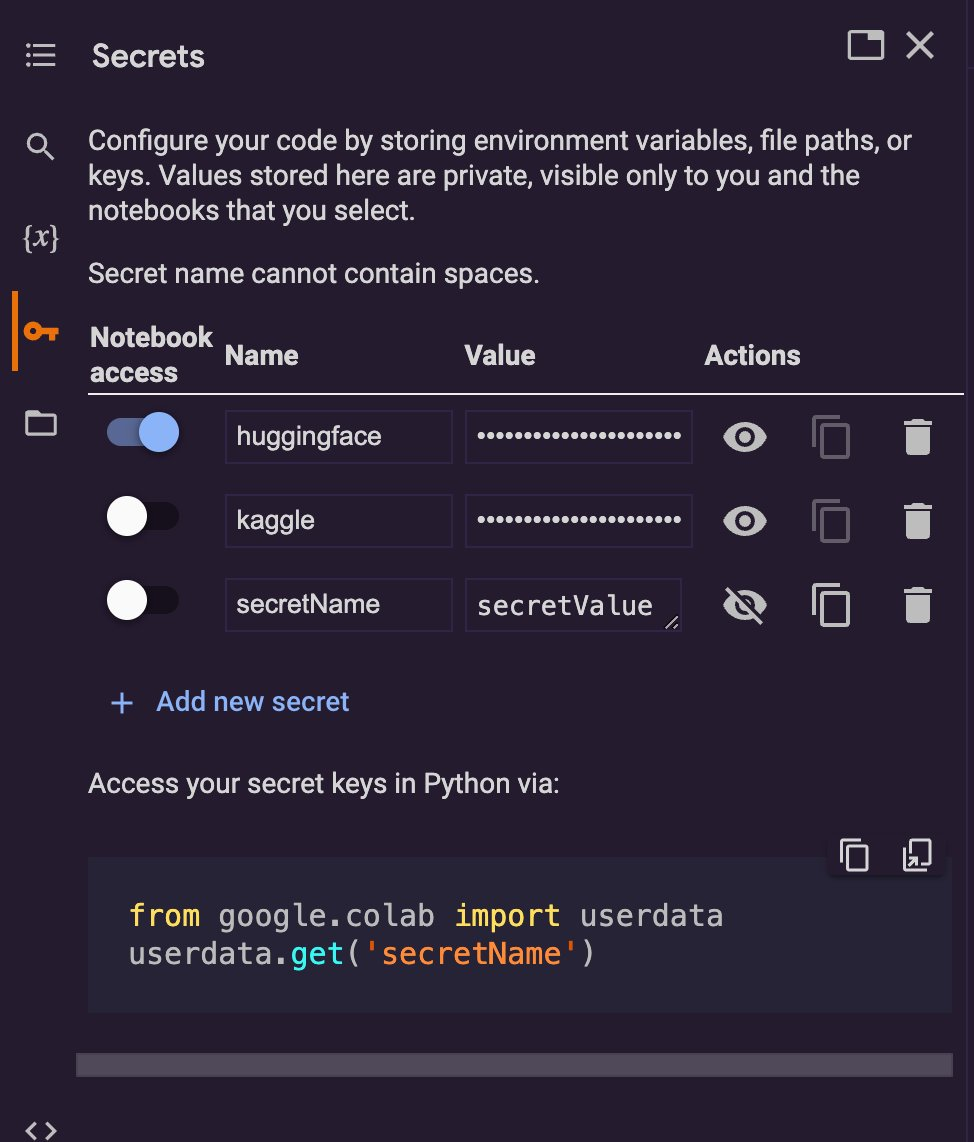

In [2]:
%%capture
%pip uninstall -y torch transformers tokenizers sentence-transformers

%pip install torch --index-url https://download.pytorch.org/whl/cu121
%pip install transformers==4.39.3 tokenizers==0.15.2
%pip install sentence-transformers==2.6.1

%pip install -U langchain pandas qdrant-client python-calamine openai brave

In [3]:
from google.colab import userdata
import os
ROUTE = userdata.get("ROUTE")
OPENAI_KEY = userdata.get("OPENAI_KEY")
os.environ["OPENAI_API_KEY"] = OPENAI_KEY
BRAVE_KEY = userdata.get("BRAVE_KEY")
QDRANT_HOST = userdata.get("QDRANT_HOST")
QDRANT_API_KEY = userdata.get("QDRANT_API_KEY")

In [7]:
from typing import List, Literal, Annotated
from typing_extensions import TypedDict
from operator import add
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field
import json

%%capture
%pip install -U langchain
%pip install -U pandas
%pip install -U qdrant
%pip install -U python-calamine
%pip install -U openai
%pip install -U brave
%pip install -U sentence_transformers
%pip install -U torch

### 👨‍💻 1. Preparación de datos
Como queremos que nuestro agente corrobore la información de internet contra una base de datos verficada, cargaremos los datos del [FakeNewsCorpusSpanish](https://github.com/jpposadas/FakeNewsCorpusSpanish/tree/master).

Ya que no entrenaremos ningun modelo, utilizaremos como dataset la una combinación de `development.xlsx`, `test.xlsx`, `train.xlsx`.

In [8]:
import pandas as pd
file_name = "fake_news_corpus_spanish.csv"

df = pd.read_csv(ROUTE + file_name)
df.head()

,Id,Category,Topic,Source,Headline,Text,Link
0,1,Fake,Education,El Ruinaversal,MAESTRA DE *NUMBER* AÑOS QUE TUVO RELACIONES C...,MAESTRA DE *NUMBER* AÑOS QUE TUVO RELACIONES C...,http://www.elruinaversal.com/2017/06/04/maestr...
1,2,TRUE,Education,Heraldo,Oxford lanza sus propios exámenes de certifica...,Oxford lanza sus propios exámenes de certifica...,https://www.heraldo.es/noticias/sociedad/2017/...
2,3,TRUE,Education,abc,La RAE estudia incluir «machirulo» en el Dicci...,La RAE estudia incluir «machirulo» en el Dicci...,https://www.abc.es/cultura/abci-estudia-inclui...
3,4,TRUE,Education,El país,Malala Yousafzai anuncia que estudiará en Oxford,Malala Yousafzai anuncia que estudiará en Oxfo...,https://elpais.com/internacional/2017/08/17/ac...
4,5,Fake,Education,El Ruinaversal,Nombran a Ricardo Arjona nuevo miembro de la R...,Nombran a Ricardo Arjona nuevo miembro de la R...,http://www.elruinaversal.com/2017/06/25/nombra...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1543 entries, 0 to 1542
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        1543 non-null   int64 
 1   Category  1543 non-null   object
 2   Topic     1543 non-null   object
 3   Source    1536 non-null   object
 4   Headline  1471 non-null   object
 5   Text      1543 non-null   object
 6   Link      1540 non-null   object
dtypes: int64(1), object(6)
memory usage: 84.5+ KB


#### 1.1 Generación de embeddings
Para ello utilizaremos [microsoft/Multilingual-MiniLM-L12-H384](https://huggingface.co/microsoft/Multilingual-MiniLM-L12-H384). Generaremos el embedding del texto.

In [10]:
from sentence_transformers import SentenceTransformer
import torch
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# Cargar modelo correctamente (sentence-transformers)
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

st_model = SentenceTransformer(
    model_name,
    device=device
)

print(f"✅ Modelo cargado en {device}")

# Función encode compatible con tu código
def encode_text(text, show_progress_bar=False):
    """
    Genera embeddings (100% compatibles con SentenceTransformer)
    """
    return st_model.encode(
        text,
        show_progress_bar=show_progress_bar,
        normalize_embeddings=False
    )

# Wrapper para compatibilidad
class ModelWrapper:
    def encode(self, text, show_progress_bar=False):
        return encode_text(text, show_progress_bar)

    def to(self, device):
        return self  # no-op, ya está en device

model = ModelWrapper()

# Verificar
test = model.encode("prueba")
print(f"✅ Funcionando correctamente: shape {test.shape}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/526 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Modelo cargado en cuda
✅ Funcionando correctamente: shape (384,)


In [11]:
# Eliminar registros sin titular
df = df[df.Headline.notna()].reset_index(drop=True)

In [12]:
from pathlib import Path

my_file = Path(ROUTE + "fake_news_corpus_spanish_title.parquet")

if my_file.is_file():
    df = pd.read_parquet(ROUTE + "fake_news_corpus_spanish_title.parquet")
else:
    # Generar embeddings y guardar archivo
    print("Generando embeddings porque ningún archivo fue encontrado...")
    embeddings = model.encode(df["Headline"].to_list(), show_progress_bar=True)
    df["text-embeddings-miniLM"] = embeddings.tolist()

    df.to_parquet(ROUTE + "fake_news_corpus_spanish_title.parquet")

In [13]:
df.head()

,Id,Category,Topic,Source,Headline,Text,Link,text-embeddings-miniLM
0,1,Fake,Education,El Ruinaversal,MAESTRA DE *NUMBER* AÑOS QUE TUVO RELACIONES C...,MAESTRA DE *NUMBER* AÑOS QUE TUVO RELACIONES C...,http://www.elruinaversal.com/2017/06/04/maestr...,"[0.11414247006177902, 0.009650100953876972, 0...."
1,2,TRUE,Education,Heraldo,Oxford lanza sus propios exámenes de certifica...,Oxford lanza sus propios exámenes de certifica...,https://www.heraldo.es/noticias/sociedad/2017/...,"[0.05469466373324394, -0.009441301226615906, 0..."
2,3,TRUE,Education,abc,La RAE estudia incluir «machirulo» en el Dicci...,La RAE estudia incluir «machirulo» en el Dicci...,https://www.abc.es/cultura/abci-estudia-inclui...,"[0.09528583288192749, -0.02415512129664421, -0..."
3,4,TRUE,Education,El país,Malala Yousafzai anuncia que estudiará en Oxford,Malala Yousafzai anuncia que estudiará en Oxfo...,https://elpais.com/internacional/2017/08/17/ac...,"[0.11644496768712997, -0.02345440350472927, 0...."
4,5,Fake,Education,El Ruinaversal,Nombran a Ricardo Arjona nuevo miembro de la R...,Nombran a Ricardo Arjona nuevo miembro de la R...,http://www.elruinaversal.com/2017/06/25/nombra...,"[0.07895777374505997, 0.020016871392726898, 0...."


### 📄 2. Qdrant

Para guardar los embeddings generados y poder buscar datos por similitud semántica, crearemos una base de datos vectorial. Para ello utilizaremos [Qdrant](https://qdrant.tech/), en especifico su cloud que proporciona despliegue de máquinas pequeñas de forma gratuita.

%%capture
%pip install -U qdrant-client\

In [5]:
%%capture
%pip install -U qdrant-client

In [14]:
QDRANT_COLLECTION_NAME = "fake-news-corpus"

In [15]:
from qdrant_client import QdrantClient

qdrant_client = QdrantClient(url=QDRANT_HOST, api_key=QDRANT_API_KEY)
print(qdrant_client.get_collections())

collections=[CollectionDescription(name='fake-news-corpus')]


In [16]:
from qdrant_client.models import Distance, VectorParams

# Comprobamos si ya existe, en caso de que no la crearíamos
if not qdrant_client.collection_exists(collection_name=QDRANT_COLLECTION_NAME):
    qdrant_client.create_collection(
        collection_name=QDRANT_COLLECTION_NAME,
        vectors_config={
            "text/miniLM-384": VectorParams(size=384, distance=Distance.COSINE), # Utilizamos cosine porque los embeddings no están normalizados
        }
    )

In [17]:
df.head()

,Id,Category,Topic,Source,Headline,Text,Link,text-embeddings-miniLM
0,1,Fake,Education,El Ruinaversal,MAESTRA DE *NUMBER* AÑOS QUE TUVO RELACIONES C...,MAESTRA DE *NUMBER* AÑOS QUE TUVO RELACIONES C...,http://www.elruinaversal.com/2017/06/04/maestr...,"[0.11414247006177902, 0.009650100953876972, 0...."
1,2,TRUE,Education,Heraldo,Oxford lanza sus propios exámenes de certifica...,Oxford lanza sus propios exámenes de certifica...,https://www.heraldo.es/noticias/sociedad/2017/...,"[0.05469466373324394, -0.009441301226615906, 0..."
2,3,TRUE,Education,abc,La RAE estudia incluir «machirulo» en el Dicci...,La RAE estudia incluir «machirulo» en el Dicci...,https://www.abc.es/cultura/abci-estudia-inclui...,"[0.09528583288192749, -0.02415512129664421, -0..."
3,4,TRUE,Education,El país,Malala Yousafzai anuncia que estudiará en Oxford,Malala Yousafzai anuncia que estudiará en Oxfo...,https://elpais.com/internacional/2017/08/17/ac...,"[0.11644496768712997, -0.02345440350472927, 0...."
4,5,Fake,Education,El Ruinaversal,Nombran a Ricardo Arjona nuevo miembro de la R...,Nombran a Ricardo Arjona nuevo miembro de la R...,http://www.elruinaversal.com/2017/06/25/nombra...,"[0.07895777374505997, 0.020016871392726898, 0...."


In [18]:
from qdrant_client.models import PointStruct

points = []
for i, link in enumerate(df["Link"]):
  payload = {
      "category": df. at[i, "Category"],
      "topic": df. at[i, "Topic"],
      "source": df. at[i, "Source"],
      "headline": df. at[i, "Headline"],
      "text": df. at[i, "Text"],
      "link": link
  }
  points.append(PointStruct(id = i, vector = {"text/miniLM-384": df.at[i, "text-embeddings-miniLM"]}, payload = payload))

In [19]:
operation_info = qdrant_client.upsert(
    collection_name=QDRANT_COLLECTION_NAME,
    wait=True,
    points=points,
)

print(operation_info)

operation_id=12 status=<UpdateStatus.COMPLETED: 'completed'>


##### Testear que funciona

In [20]:
query_embedding = model.encode("""La CIA revela que Hitler no murió en Berlin porque escapó a Colombia?""", show_progress_bar=True)
qdrant_client = QdrantClient(url=QDRANT_HOST, api_key=QDRANT_API_KEY)

search_result = qdrant_client.query_points(
    collection_name=QDRANT_COLLECTION_NAME,
    query=query_embedding,
    with_payload=True,
    limit=5,
    using="text/miniLM-384",
).points

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
search_result[0]

ScoredPoint(id=631, version=12, score=0.037945174, payload={'category': 'TRUE', 'topic': 'Sport', 'source': 'El país', 'headline': '"Nadie puede estar contento, México no avanza"', 'text': '"Nadie puede estar contento, México no avanza"\nLos futbolistas mexicanos lamentan su derrota contra Brasil y el hecho de hilar siete Mundiales sin clasificarse a cuartos de final\nEl Mundial ha terminado para México. La Brasil de Neymar se encargó de sacar del camino al Tri *NUMBER*-*NUMBER*. El conjunto mexicano ha hilado una cifra negra para sus ambiciones: siete Mundiales sin clasificarse a cuartos de final. "[Estoy] tranquilo por lo realizado en este Mundial y nadie puede estar contento, México no avanza y así es el fútbol", estimó Guillermo Ochoa, uno de los más destacados. "Cada quien pone lo mejor de uno. Desde la cancha nos faltó precisión en los momentos donde podíamos hacer daño", agregó Ochoa, el portero que contabilizó *NUMBER* atajadas durante cuatro partidos, la mayor cifra en esta Co

### 🌐 3. Brave Search

Para la búsqueda en internet utilizaremos [Brave Search](https://brave.com/search/api/), la API más grande del mundo para llevar a cabo esta tarea. La documentación específica sobre su implementación se encuentra aquí: [Brave Web Search API](https://api-dashboard.search.brave.com/app/documentation/web-search/get-started) docs.

In [22]:
import requests
from typing import Optional, Any

class BraveSearchClient:
    def __init__(self):
        self.api_key = BRAVE_KEY
        self.base_url = "https://api.search.brave.com/res/v1/news/search"

    def search(
        self,
        q: str,                             # query
        count: int = 10,                    # Nº de registros que buscar
        freshness: Optional[str] = None,    # Filtro por reciente
        search_lang: str = "es",             # Lengua de búsqueda
    ) -> dict[str, Any]:

        params: dict[str, Any] = {
            "q": q,
            "count": count,
            "freshness": freshness,
            "search_lang": search_lang
        }
        headers = {
            "Accept": "application/json",
            "X-Subscription-Token": self.api_key,
        }

        response = requests.get(self.base_url, headers=headers, params=params)
        response.raise_for_status()
        return response.json()

#### Test it works

In [23]:
client = BraveSearchClient()
resp = client.search(q="python web scraping", count=5)
print(resp)

{'type': 'news', 'query': {'original': 'python web scraping', 'spellcheck_off': False, 'show_strict_warning': False}, 'results': [{'type': 'news_result', 'title': 'A Practical Introduction to Web Scraping in Python – Real Python', 'url': 'https://realpython.com/python-web-scraping-practical-introduction/', 'description': "In this tutorial, you'll learn all about web scraping in Python. You'll see how to parse data from websites and interact with HTML forms using tools such as Beautiful Soup and MechanicalSoup.", 'age': 'December 21, 2024', 'page_age': '2024-12-21T14:00:00', 'meta_url': {'scheme': 'https', 'netloc': 'realpython.com', 'hostname': 'realpython.com', 'favicon': 'https://imgs.search.brave.com/JQ43CVi7H9f72QglOvL-EsjUDRpEhkWaC1oTBUBouxE/rs:fit:32:32:1:0/g:ce/aHR0cDovL2Zhdmlj/b25zLnNlYXJjaC5i/cmF2ZS5jb20vaWNv/bnMvNWNjZGM4YTE0/ZTJkY2FhMGNlOWNi/OTEyYjFlM2JmNmRk/NGY3MDk4ZmY2MzFj/ZjUyMTAwN2ZjODk2/MGIxYzAxZC9yZWFs/cHl0aG9uLmNvbS8', 'path': '› python-web-scraping-practical-introduct

In [24]:
resp['results'][0]

{'type': 'news_result',
 'title': 'A Practical Introduction to Web Scraping in Python – Real Python',
 'url': 'https://realpython.com/python-web-scraping-practical-introduction/',
 'description': "In this tutorial, you'll learn all about web scraping in Python. You'll see how to parse data from websites and interact with HTML forms using tools such as Beautiful Soup and MechanicalSoup.",
 'age': 'December 21, 2024',
 'page_age': '2024-12-21T14:00:00',
 'meta_url': {'scheme': 'https',
  'netloc': 'realpython.com',
  'hostname': 'realpython.com',
  'favicon': 'https://imgs.search.brave.com/JQ43CVi7H9f72QglOvL-EsjUDRpEhkWaC1oTBUBouxE/rs:fit:32:32:1:0/g:ce/aHR0cDovL2Zhdmlj/b25zLnNlYXJjaC5i/cmF2ZS5jb20vaWNv/bnMvNWNjZGM4YTE0/ZTJkY2FhMGNlOWNi/OTEyYjFlM2JmNmRk/NGY3MDk4ZmY2MzFj/ZjUyMTAwN2ZjODk2/MGIxYzAxZC9yZWFs/cHl0aG9uLmNvbS8',
  'path': '› python-web-scraping-practical-introduction'},
 'thumbnail': {'src': 'https://imgs.search.brave.com/j2frhgOC5FZ-SiOZ-WJwdmn95ux0QHqg3ocgMUG0l4s/rs:fit:200:2

### 🤖 4. Crear Agente de Langgraph
Nuestro agente lo crearemos utilizando Langgraph, la documentación se puede encontrar aquí: [LangGraph Docs](https://langchain-ai.github.io/langgraph/concepts/why-langgraph/). Esta herramienta permite crear a desarrolladores, herramientas robustas basadas en IA como agentes con flujos inteligentes.

%%capture
%pip install -U langgraph
%pip install -U langchain-openai

In [6]:
%%capture
%pip install -U langgraph
%pip install -U langchain-openai

In [60]:
from typing import List, Annotated, Any
from typing_extensions import TypedDict
from operator import add
from langgraph.graph import StateGraph, END

def keep_first_value(left: Any, right: Any) -> Any:
    if left is not None:
        return left
    return right

class AgentState(TypedDict):
    # Pregunta
    question: str
    rewritten_question: str

    # Documentos recuperados
    documents_qdrant: Annotated[List[dict], add]
    documents_web: Annotated[List[dict], add]

    # Respuestas
    draft_answer: str
    final_answer: str

    # Control agéntico
    validation_feedback: str
    validation_passed: bool
    retry_count: int
    max_retries: int


In [61]:
class AgentConfig:
    """Configuración del agente"""
    MAIN_MODEL = "gpt-4o"
    VALIDATION_MODEL = "gpt-4o-mini"
    MAX_RETRIES = 2
    QUALITY_THRESHOLD = 0.7

#### 4.1 Crear los nodos

In [62]:
from langchain_openai import ChatOpenAI

def rewrite_query(state: AgentState) -> AgentState:
    """Reescribe la pregunta para mejorar la búsqueda"""
    print("\n🔄 Reescribiendo pregunta...")

    llm = ChatOpenAI(model=AgentConfig.VALIDATION_MODEL, temperature=0)
    original_question = state.get("question", "")

    # Si es primer intento, usar pregunta original
    if state.get("retry_count", 0) == 0:
        print(f"  Intento 1: {original_question}")
        return {
            **state,
            "rewritten_question": original_question
        }

    # Si es retry, mejorar con feedback
    feedback = state.get("validation_feedback", "")

    prompt = f"""
    Reescribe esta pregunta para mejorar la búsqueda de información.

    Pregunta original: {original_question}
    Problema del intento anterior: {feedback}

    Hazla más específica y usa términos de búsqueda efectivos.
    Responde SOLO con la pregunta reescrita.
    """

    response = llm.invoke(prompt)
    rewritten = response.content.strip()

    print(f"  Intento {state.get('retry_count', 0) + 1}: {rewritten}")

    return {
        **state,
        "rewritten_question": rewritten
    }

##### 4.1.a Búsqueda en base de datos

In [63]:
def retrieve_qdrant(state: AgentState) -> dict:
    """Busca en Qdrant"""

    query = state.get("rewritten_question") or state.get("question", "")

    if not query:
        return {"documents_qdrant": []}

    print(f"  🔍 Buscando en Qdrant...")

    try:
        query_embedding = model.encode(query, show_progress_bar=False)
        qdrant_client = QdrantClient(url=QDRANT_HOST, api_key=QDRANT_API_KEY)

        search_result = qdrant_client.query_points(
            collection_name=QDRANT_COLLECTION_NAME,
            query=query_embedding,
            with_payload=True,
            limit=15,  # ← Aumentado de 3 a 15
            using="text/miniLM-384",
        ).points

        processed_results = []
        for result in search_result:
            processed_results.append({
                "title": result.payload['headline'],
                "text": result.payload['text'],
                "source": result.payload['source'],
                "category": result.payload['category']
            })

        print(f"     ✅ {len(processed_results)} documentos recuperados")
        return {"documents_qdrant": processed_results}

    except Exception as e:
        print(f"     ❌ Error: {e}")
        return {"documents_qdrant": []}

##### 4.1.b Búsqueda en internet

In [64]:
def retrieve_web(state: AgentState) -> dict:
    """Busca en web"""

    client = BraveSearchClient()
    query = state.get("rewritten_question") or state.get("question", "")

    if not query:
        return {"documents_web": []}

    print(f"  🔍 Buscando en web...")

    try:
        resp = client.search(q=query, count=15)  # ← Aumentado de 3 a 15

        processed_results = []
        for result in resp.get('results', []):
            processed_results.append({
                "title": result['title'],
                "text": result['description'],
                "source": result['meta_url']['hostname'],
            })

        print(f"     ✅ {len(processed_results)} documentos recuperados")
        return {"documents_web": processed_results}

    except Exception as e:
        print(f"     ❌ Error: {e}")
        return {"documents_web": []}

4.2.f Generar respuesta preliminar

In [65]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
import json

def generate_draft(state: AgentState) -> AgentState:
    """Genera respuesta usando TODAS las fuentes"""
    print("\n✍️ Generando respuesta...")

    llm = ChatOpenAI(model=AgentConfig.MAIN_MODEL, temperature=0)

    bbdd_docs = state.get("documents_qdrant", [])
    web_docs = state.get("documents_web", [])
    question = state.get("rewritten_question") or state.get("question", "")

    print(f"  📊 Usando {len(bbdd_docs)} docs de BD + {len(web_docs)} docs web")

    # Prompt original que funcionaba
    prompt = f"""Eres un "Contrastador de información". Entrada:
- question (pregunta del usuario)
- bbdd_docs (lista de documentos de la base de datos revisados y etiquetados como Verdadero o Fake)
- web_docs (lista de documentos web)

Objetivo: responder contrastando la información de la BD con la información encontrada en la web.

1. Para cada documento relevante de la BD:
   a) Si label = Verdadero: busca corroboración en web_docs.
       - Si la web aporta fuentes que concuerdan → marcar "Confirmado".
       - Si la web contradice o no hay corroboración → explicar que el contenido de la web puede ser falso.
   b) Si label = Fake: busca si la web replica la información falsa.
       - Si la web la replica → marcar "Posible desinformación replicada" y mostrar evidencias.
       - Si la web la contradice → marcar "BD falsa" (explicar).

2. Siempre incluye:
   - Resumen claro (un párrafo explicativo).
   - Evidencias extraídas de BD y Web referenciando la fuente.
   - Señalización explícita de contradicciones.

Reglas:
- Prioriza fuentes autoritativas.
- Nunca digas nada que no aparezca en los documentos.
- Da el output en markdown organizado.

question: {question}

bbdd_docs:
{json.dumps(bbdd_docs, indent=2, ensure_ascii=False)}

web_docs:
{json.dumps(web_docs, indent=2, ensure_ascii=False)}
"""

    try:
        if not bbdd_docs and not web_docs:
            draft = "No hay información relevante para responder la pregunta."
        else:
            response = llm.invoke(prompt)
            draft = response.content

        print(f"  ✅ Respuesta generada ({len(draft)} caracteres)")

        return {
            **state,
            "draft_answer": draft
        }

    except Exception as e:
        print(f"  ❌ Error: {e}")
        return {
            **state,
            "draft_answer": "Error al generar respuesta."
        }

In [66]:
class AnswerValidation(BaseModel):
    """Esquema para validación de respuesta"""
    is_complete: bool = Field(description="Si la respuesta es completa")
    addresses_question: bool = Field(description="Si responde directamente la pregunta")
    has_evidence: bool = Field(description="Si tiene evidencias de las fuentes")
    overall_quality: float = Field(description="Calidad general 0-1")
    feedback: str = Field(description="Qué falta o qué mejorar")

def validate_answer(state: AgentState) -> AgentState:
    """Valida la respuesta final"""
    print("\n🔎 Validando respuesta final...")

    llm = ChatOpenAI(model=AgentConfig.VALIDATION_MODEL, temperature=0)
    llm_with_structure = llm.with_structured_output(AnswerValidation)

    prompt = f"""
    Evalúa si esta respuesta es adecuada para entregar al usuario.

    PREGUNTA: {state['question']}

    RESPUESTA:
    {state['draft_answer']}

    Evalúa:
    1. ¿Responde directamente a la pregunta?
    2. ¿Es completa?
    3. ¿Tiene evidencias de las fuentes?
    4. ¿La calidad es alta?
    """

    try:
        validation = llm_with_structure.invoke([
            SystemMessage(content="Eres un evaluador crítico de respuestas."),
            HumanMessage(content=prompt)
        ])

        passed = (
            validation.is_complete and
            validation.addresses_question and
            validation.has_evidence and
            validation.overall_quality >= AgentConfig.QUALITY_THRESHOLD
        )

        status = "✅ APROBADA" if passed else "❌ RECHAZADA"
        print(f"  {status} - Calidad: {validation.overall_quality:.2f}")
        print(f"  Feedback: {validation.feedback}")

        return {
            **state,
            "validation_feedback": validation.feedback,
            "validation_passed": passed
        }

    except Exception as e:
        print(f"  ⚠️ Error en validación: {e}")
        return {
            **state,
            "validation_feedback": "",
            "validation_passed": True
        }

In [67]:
def decide_next_step(state: AgentState) -> Literal["retry", "finalize", "end"]:
    """Decide si hacer retry o finalizar"""

    retry_count = state.get("retry_count", 0)
    max_retries = state.get("max_retries", AgentConfig.MAX_RETRIES)

    print(f"\n🤔 Decidiendo... (Intento {retry_count + 1}/{max_retries + 1})")

    if state.get("validation_passed", False):
        print("  ✅ Respuesta validada")
        return "finalize"

    if retry_count >= max_retries:
        print(f"  ⚠️ Máximo de intentos alcanzado")
        return "end"

    print("  🔄 Reintentando...")
    return "retry"

def increment_retry(state: AgentState) -> AgentState:
    """Incrementa contador"""
    retry_count = state.get("retry_count", 0) + 1
    return {**state, "retry_count": retry_count}

def finalize(state: AgentState) -> AgentState:
    """Finaliza con éxito"""
    print("\n✅ Respuesta validada")
    return {**state, "final_answer": state.get("draft_answer", "")}

def end_best_effort(state: AgentState) -> AgentState:
    """Finaliza con disclaimer"""
    print("\n⚠️ Entregando mejor respuesta disponible")
    answer = state.get("draft_answer", "")
    disclaimer = "\n\n⚠️ Nota: Esta respuesta puede requerir verificación adicional."
    return {**state, "final_answer": answer + disclaimer}

#### 4.3 Construir el grafo con loops

In [68]:
def build_agentic_rag_graph():
    """Construye el grafo agéntico"""

    workflow = StateGraph(AgentState)

    # Añadir nodos
    workflow.add_node("rewrite_query", rewrite_query)
    workflow.add_node("retrieve_qdrant", retrieve_qdrant)
    workflow.add_node("retrieve_web", retrieve_web)
    workflow.add_node("generate_draft", generate_draft)
    workflow.add_node("validate_answer", validate_answer)
    workflow.add_node("increment_retry", increment_retry)
    workflow.add_node("finalize", finalize)
    workflow.add_node("end_best_effort", end_best_effort)

    # Flujo principal
    workflow.set_entry_point("rewrite_query")

    # Búsqueda paralela
    workflow.add_edge("rewrite_query", "retrieve_qdrant")
    workflow.add_edge("rewrite_query", "retrieve_web")

    # Generación
    workflow.add_edge("retrieve_qdrant", "generate_draft")
    workflow.add_edge("retrieve_web", "generate_draft")

    # Validación
    workflow.add_edge("generate_draft", "validate_answer")

    # Decisión
    workflow.add_conditional_edges(
        "validate_answer",
        decide_next_step,
        {
            "retry": "increment_retry",
            "finalize": "finalize",
            "end": "end_best_effort"
        }
    )

    # Loop
    workflow.add_edge("increment_retry", "rewrite_query")

    # Finales
    workflow.add_edge("finalize", END)
    workflow.add_edge("end_best_effort", END)

    return workflow.compile()

In [69]:
def print_graph_structure(graph):
    """Imprime la estructura del grafo para visualización"""
    print("\n" + "="*60)
    print("📊 ESTRUCTURA DEL GRAFO AGÉNTICO RAG")
    print("="*60)

    print("\n🔷 NODOS:")
    for node in graph.nodes:
        print(f"   • {node}")

    print("\n🔀 FLUJO:")
    print("   1. rewrite_query (mejora la pregunta)")
    print("   2. retrieve_qdrant + retrieve_web (paralelo)")
    print("   3. generate_draft (genera respuesta)")
    print("   4. validate_answer (valida calidad)")
    print("   5. decide_next_step (decisión inteligente)")
    print("      ├─ Si validación OK → finalize")
    print("      ├─ Si validación falla → increment_retry → loop a 1")
    print("      └─ Si max intentos → end_best_effort")

    print("\n🔄 LOOPS:")
    print("   • Loop de razonamiento: hasta 2 reintentos")
    print("   • Mejora automática de pregunta en cada retry")

    print("\nℹ️ CARACTERÍSTICAS:")
    print("   • RAG con validación agéntica")
    print("   • 15 documentos de Qdrant + 15 de Web")
    print("   • Validación solo de respuesta final")
    print("   • Loop inteligente con feedback")
    print("   • Prompt de contrastación de información")

    print("="*60 + "\n")

In [70]:
# Construir el grafo
graph = build_agentic_rag_graph()
print("✅ Grafo construido correctamente")

✅ Grafo construido correctamente


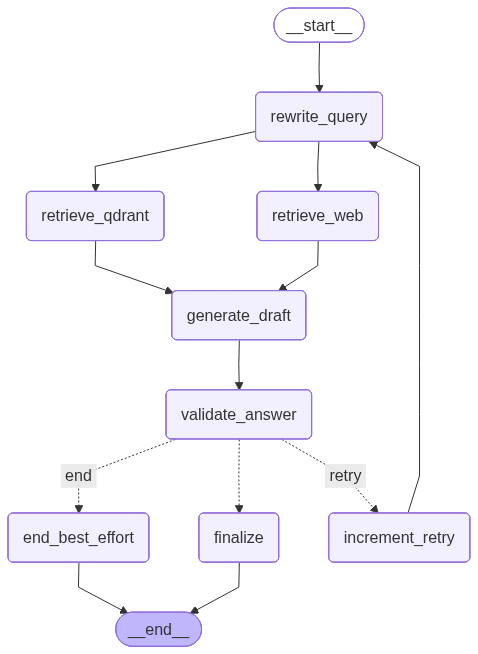

In [71]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

#### 4.4 Ejecutamos el grafo

In [72]:
from IPython.display import display, Markdown

def stream_graph_updates(user_input: str):
    """Ejecuta el grafo"""

    initial_state = {
        "question": user_input,
        "rewritten_question": "",
        "documents_qdrant": [],
        "documents_web": [],
        "draft_answer": "",
        "final_answer": "",
        "validation_feedback": "",
        "validation_passed": False,
        "retry_count": 0,
        "max_retries": AgentConfig.MAX_RETRIES
    }

    print(f"\n{'='*70}")
    print(f"🚀 PREGUNTA: {user_input}")
    print(f"{'='*70}")

    for event in graph.stream(initial_state):
        for node_name, node_output in event.items():
            if node_name in ["finalize", "end_best_effort"]:
                print(f"\n{'='*70}")
                print("📝 RESPUESTA FINAL:")
                print(f"{'='*70}\n")
                display(Markdown(node_output.get("final_answer", "")))
                print(f"\n{'='*70}\n")

In [73]:
def run_agentic_rag(question: str, verbose: bool = True):
    """
    Ejecuta el agente RAG y devuelve el estado final (para producción)
    """

    # Estado inicial completo con todos los campos necesarios
    initial_state = {
        "question": question,
        "rewritten_question": "",
        "documents_qdrant": [],
        "documents_web": [],
        "draft_answer": "",
        "final_answer": "",
        "validation_feedback": "",
        "validation_passed": False,
        "retry_count": 0,
        "max_retries": AgentConfig.MAX_RETRIES
    }

    if verbose:
        print(f"\n{'='*70}")
        print(f"🚀 PREGUNTA: {question}")
        print(f"{'='*70}\n")

    # Ejecutar el grafo
    final_state = graph.invoke(initial_state)

    if verbose:
        print("\n" + "=" * 70)
        print("📝 RESPUESTA FINAL")
        print("=" * 70 + "\n")

        from IPython.display import display, Markdown
        display(Markdown(final_state.get("final_answer", "")))

        print("\n" + "=" * 70)
        print("📊 ESTADÍSTICAS:")
        print(f"   • Intentos realizados: {final_state.get('retry_count', 0) + 1}")
        print(f"   • Validación exitosa: {'Sí' if final_state.get('validation_passed', False) else 'No'}")
        print(f"   • Docs Qdrant: {len(final_state.get('documents_qdrant', []))}")
        print(f"   • Docs Web: {len(final_state.get('documents_web', []))}")
        print("=" * 70 + "\n")

    return final_state

### Comaparación estre desarrollo y producción

##### Para desarrollo/debugging

In [74]:
stream_graph_updates("El hombre no llegó a la Luna")


🚀 PREGUNTA: El hombre no llegó a la Luna

🔄 Reescribiendo pregunta...
  Intento 1: El hombre no llegó a la Luna
  🔍 Buscando en Qdrant...
  🔍 Buscando en web...
     ✅ 15 documentos recuperados
     ✅ 15 documentos recuperados

✍️ Generando respuesta...
  📊 Usando 15 docs de BD + 15 docs web
  ✅ Respuesta generada (2437 caracteres)

🔎 Validando respuesta final...
  ✅ APROBADA - Calidad: 0.90
  Feedback: La respuesta es completa y aborda directamente la pregunta, proporcionando evidencias de diversas fuentes. Sin embargo, podría mejorar al incluir un análisis más crítico de las teorías de conspiración y su impacto en la percepción pública.

🤔 Decidiendo... (Intento 1/3)
  ✅ Respuesta validada

✅ Respuesta validada

📝 RESPUESTA FINAL:



```markdown
## Resumen

La afirmación de que el hombre no llegó a la Luna es una teoría de conspiración que ha sido ampliamente debatida. Aunque algunos documentos de la web reflejan que una parte de la población duda de la llegada del hombre a la Luna, la evidencia científica y los registros históricos confirman que el alunizaje ocurrió en 1969. La información de la base de datos no contiene documentos etiquetados como "Verdadero" o "Fake" sobre este tema, por lo que se ha contrastado únicamente con fuentes web.

## Evidencias

### Fuentes que confirman la llegada a la Luna

1. **National Geographic**: Desmonta la teoría de la conspiración sobre la llegada del hombre a la Luna, afirmando que Neil Armstrong y Buzz Aldrin fueron los primeros en pisar la superficie lunar el 20 de julio de 1969. [Fuente](https://www.nationalgeographic.com.es)

2. **Hombre Geológico**: Reitera que el alunizaje de 1969 fue real y desmonta la falsa creencia de que no ocurrió. [Fuente](https://geologicalmanblog.wordpress.com)

3. **Milenio**: Detalla el primer viaje a la Luna, incluyendo fechas, protagonistas y datos clave, confirmando el éxito de la misión Apolo 11. [Fuente](https://www.milenio.com)

### Fuentes que reflejan escepticismo

1. **ABC**: Menciona que un 22% de los españoles cree que el hombre no llegó a la Luna. [Fuente](https://www.abc.es)

2. **El Español**: Indica que solo el 63% de los españoles está totalmente seguro de que el hombre llegó a la Luna. [Fuente](https://elespanol.com)

3. **El Mundo**: Reporta que un 22% de los españoles no está totalmente seguro de la llegada del hombre a la Luna. [Fuente](https://www.elmundo.es)

### Fuentes que confirman misiones futuras

1. **Hola**: Informa sobre la misión Artemis II de la NASA, que planea llevar a astronautas a sobrevolar la Luna, marcando el regreso humano al espacio. [Fuente](https://hola.com)

2. **Wired**: Detalla la misión Artemis II, que llevará a cuatro astronautas a sobrevolar la Luna, inaugurando una nueva era lunar. [Fuente](https://es.wired.com)

## Conclusión

La evidencia científica y los registros históricos confirman que el hombre llegó a la Luna en 1969. Aunque existe un sector de la población que duda de este hecho, las misiones futuras de la NASA, como Artemis II, continúan reafirmando el compromiso con la exploración lunar. Las teorías de conspiración carecen de fundamento sólido frente a la abrumadora evidencia disponible.
```

##### Para obtener solo el resultado

In [75]:
result = run_agentic_rag("El hombre no llegó a la Luna")
print(result['final_answer'])


🚀 PREGUNTA: El hombre no llegó a la Luna


🔄 Reescribiendo pregunta...
  Intento 1: El hombre no llegó a la Luna
  🔍 Buscando en Qdrant...
  🔍 Buscando en web...
     ✅ 15 documentos recuperados
     ✅ 15 documentos recuperados

✍️ Generando respuesta...
  📊 Usando 15 docs de BD + 15 docs web
  ✅ Respuesta generada (2164 caracteres)

🔎 Validando respuesta final...
  ✅ APROBADA - Calidad: 0.90
  Feedback: La respuesta es muy completa y aborda la pregunta de manera directa, proporcionando evidencias de fuentes confiables. Sin embargo, podría mejorar al incluir un resumen más conciso de las evidencias y una referencia más clara a la importancia de la evidencia científica frente a las teorías de conspiración.

🤔 Decidiendo... (Intento 1/3)
  ✅ Respuesta validada

✅ Respuesta validada

📝 RESPUESTA FINAL



```markdown
## Resumen

La afirmación de que el hombre no llegó a la Luna es una teoría de conspiración que ha sido ampliamente refutada por múltiples fuentes autoritativas. Aunque una parte de la población sigue dudando de la veracidad de las misiones lunares, la evidencia científica y los registros históricos confirman que el alunizaje ocurrió. La información de la base de datos no contiene documentos etiquetados como "Verdadero" o "Fake" sobre este tema, pero los documentos web proporcionan suficiente evidencia para confirmar la llegada del hombre a la Luna.

## Evidencias

### Documentos Web

1. **National Geographic**: Desmonta la teoría de la conspiración sobre la llegada del hombre a la Luna, afirmando que Neil Armstrong y Buzz Aldrin fueron los primeros en pisar la superficie lunar el 20 de julio de 1969. [Fuente](https://www.nationalgeographic.com.es).

2. **Hombre Geológico**: Reitera que el alunizaje de 1969 fue real y desmonta la falsa creencia de que no ocurrió. [Fuente](https://geologicalmanblog.wordpress.com).

3. **Infobae**: Menciona a Eugene Cernan, el último hombre en pisar la Luna en 1972, confirmando las misiones Apolo. [Fuente](https://www.infobae.com).

4. **Milenio**: Detalla el primer viaje a la Luna, incluyendo fechas y protagonistas, reafirmando la veracidad del evento. [Fuente](https://www.milenio.com).

5. **Clarin**: Enumera las expediciones exitosas a la Luna desde 1969, confirmando múltiples misiones. [Fuente](https://www.clarin.com).

### Contradicciones

- **Encuestas de Opinión**: Algunos documentos web, como los de ABC y El Español, muestran que una parte significativa de la población española duda de la llegada del hombre a la Luna, lo que refleja la persistencia de teorías conspirativas. Sin embargo, estas opiniones no son evidencia científica y no contradicen los hechos históricos confirmados por fuentes autoritativas.

## Conclusión

La evidencia proporcionada por fuentes confiables y científicas confirma que el hombre sí llegó a la Luna. Las dudas y teorías conspirativas, aunque presentes en la opinión pública, no tienen fundamento en la evidencia científica y documental disponible.
```


📊 ESTADÍSTICAS:
   • Intentos realizados: 1
   • Validación exitosa: Sí
   • Docs Qdrant: 120
   • Docs Web: 120

```markdown
## Resumen

La afirmación de que el hombre no llegó a la Luna es una teoría de conspiración que ha sido ampliamente refutada por múltiples fuentes autoritativas. Aunque una parte de la población sigue dudando de la veracidad de las misiones lunares, la evidencia científica y los registros históricos confirman que el alunizaje ocurrió. La información de la base de datos no contiene documentos etiquetados como "Verdadero" o "Fake" sobre este tema, pero los documentos web proporcionan suficiente evidencia para confirmar la llegada del hombre a la Luna.

## Evidencias

### Documentos Web

1. **National Geographic**: Desmonta la teoría de la conspiración sobre la llegada del hombre a la Luna, afirmando que Neil Armstrong y Buzz Aldrin fueron los primeros en pisar la superficie lunar el 20 de julio de 1969. [Fuente](https://www.nationalgeographic.com.es).

2. **Hombr

##### Para Batch processing

In [77]:
# Procesar múltiples preguntas
questions = [
    "¿McDonald's tiene hamburguesas veganas?",
    "¿La hamburguesa de cempasúchil es real?",
    "¿Dónde está disponible la McVegan?"
]

print("🔄 Procesando múltiples preguntas...\n")

results = []
for i, q in enumerate(questions, 1):
    print(f"[{i}/{len(questions)}] Procesando: {q[:50]}...")

    result = run_agentic_rag(q, verbose=False)  # Sin prints detallados

    results.append({
        "question": q,
        "answer": result.get('final_answer', '')[:100] + "...",  # Primeros 100 chars
        "answer_full": result.get('final_answer', ''),  # Respuesta completa
        "retries": result.get('retry_count', 0),
        "validated": result.get('validation_passed', False),
        "docs_total": len(result.get('documents_qdrant', [])) + len(result.get('documents_web', []))
    })
    print(f"   ✅ Completado (Intentos: {result.get('retry_count', 0) + 1}, Validado: {result.get('validation_passed', False)})\n")

# Análisis
print("="*80)
print("📊 RESUMEN DE RESULTADOS")
print("="*80)

import pandas as pd
df = pd.DataFrame(results)

# Mostrar tabla resumida (sin respuestas completas)
df_summary = df[['question', 'retries', 'validated', 'docs_total']]
print(df_summary.to_string(index=False))

print("\n" + "="*80)
print(f"📈 ESTADÍSTICAS:")
print(f"   • Total preguntas: {len(questions)}")
print(f"   • Validadas exitosamente: {df['validated'].sum()}")
print(f"   • Promedio de intentos: {df['retries'].mean() + 1:.1f}")
print(f"   • Promedio de documentos: {df['docs_total'].mean():.0f}")
print("="*80)

# Ver respuestas completas individualmente
print("\n📝 RESPUESTAS COMPLETAS:\n")
for i, row in df.iterrows():
    print(f"{'='*80}")
    print(f"PREGUNTA {i+1}: {row['question']}")
    print(f"{'='*80}")
    from IPython.display import display, Markdown
    display(Markdown(row['answer_full']))
    print(f"\n{'='*80}\n")

🔄 Procesando múltiples preguntas...

[1/3] Procesando: ¿McDonald's tiene hamburguesas veganas?...

🔄 Reescribiendo pregunta...
  Intento 1: ¿McDonald's tiene hamburguesas veganas?
  🔍 Buscando en Qdrant...
  🔍 Buscando en web...
     ✅ 15 documentos recuperados
     ✅ 15 documentos recuperados

✍️ Generando respuesta...
  📊 Usando 15 docs de BD + 15 docs web
  ✅ Respuesta generada (1955 caracteres)

🔎 Validando respuesta final...
  ✅ APROBADA - Calidad: 0.90
  Feedback: La respuesta es completa y aborda la pregunta de manera directa, proporcionando información relevante sobre la disponibilidad de hamburguesas veganas en diferentes regiones. Incluye evidencias de fuentes confiables, lo que respalda la información presentada. Sin embargo, podría mejorar al resumir más claramente las diferencias entre regiones en un solo párrafo al final.

🤔 Decidiendo... (Intento 1/3)
  ✅ Respuesta validada

✅ Respuesta validada
   ✅ Completado (Intentos: 1, Validado: True)

[2/3] Procesando: ¿La hamburg

## Resumen

La pregunta sobre si McDonald's ofrece hamburguesas veganas tiene respuestas variadas dependiendo de la región. En algunos lugares, como el Reino Unido e Irlanda, McDonald's ha lanzado hamburguesas veganas, mientras que en otros, como Estados Unidos, han retirado la McPlant debido a bajas ventas. En España, McDonald's no ofrece hamburguesas veganas, lo que ha generado críticas entre los consumidores.

## Evidencias

### Base de Datos (BBDD)

No hay documentos en la base de datos que aborden directamente la pregunta sobre las hamburguesas veganas de McDonald's.

### Documentos Web

1. **VegNews**: McDonald's en Estados Unidos ha retirado la McPlant de su menú debido a bajas ventas, pero no es imposible comer a base de plantas en sus establecimientos. [Fuente](https://vegnews.com)

2. **Los Angeles Times**: McDonald's comenzará a vender una hamburguesa vegana en el Reino Unido e Irlanda. [Fuente](https://www.latimes.com)

3. **Xataka**: McDonald's ha confirmado que no volverá a ofrecer la McPlant en Estados Unidos en el futuro cercano. [Fuente](https://www.xataka.com)

4. **Gastronomía & Cía**: McDonald's aún no ha incluido una hamburguesa vegetariana en sus menús en España, aunque se está considerando. [Fuente](https://www.gastronomiaycia.com)

5. **BBC News Mundo**: McDonald's ha creado una hamburguesa sin carne que solo vende en Suecia, enfrentando desafíos para satisfacer las preocupaciones éticas y de salud de los consumidores vegetarianos. [Fuente](https://www.bbc.com)

## Conclusiones

- **Confirmado**: McDonald's ofrece hamburguesas veganas en algunos mercados como el Reino Unido e Irlanda.
- **Contradicciones**: En Estados Unidos, la McPlant ha sido retirada, lo que indica una falta de oferta consistente de hamburguesas veganas.
- **Explicación**: La falta de una oferta uniforme de hamburguesas veganas en McDonald's se debe a las diferencias en la demanda y aceptación del producto en distintos mercados.



PREGUNTA 2: ¿La hamburguesa de cempasúchil es real?


```markdown
# Análisis de la existencia de la hamburguesa de cempasúchil

## Resumen
La pregunta sobre la existencia de una hamburguesa de cempasúchil no encuentra respaldo en los documentos de la base de datos ni en las fuentes web revisadas. No se ha encontrado evidencia que confirme la existencia de tal producto en el mercado o en eventos gastronómicos. La información disponible en la web y en la base de datos no menciona específicamente una hamburguesa de cempasúchil, lo que sugiere que podría tratarse de un rumor o una invención sin base real.

## Evidencias de la Base de Datos
No hay documentos en la base de datos que mencionen la hamburguesa de cempasúchil. Los documentos revisados se centran en otros temas, como eventos deportivos, noticias de celebridades y otros productos alimenticios, pero no abordan la existencia de una hamburguesa de cempasúchil.

## Evidencias de la Web
- **El Comidista | El País**: Se menciona la decadencia de ciertos eventos gastronómicos, pero no se hace referencia a una hamburguesa de cempasúchil. [Fuente](https://elpais.com)
- **Yahoo Noticias**: Se habla sobre la flor de cempasúchil y su uso en altares, pero no se menciona su uso en hamburguesas. [Fuente](https://es-us.noticias.yahoo.com)
- **Hydro Environment**: Se proporciona información sobre el cultivo y cuidado del cempasúchil, pero no se menciona su uso en la gastronomía como ingrediente de hamburguesas. [Fuente](https://hydroenv.com.mx)

## Conclusión
No se ha encontrado evidencia que confirme la existencia de una hamburguesa de cempasúchil en los documentos revisados. La falta de información en fuentes autoritativas sugiere que la hamburguesa de cempasúchil podría no ser un producto real o ampliamente reconocido. Si bien el cempasúchil es una flor conocida y utilizada en México, especialmente en el Día de Muertos, su uso en hamburguesas no está documentado en las fuentes revisadas.
```




PREGUNTA 3: ¿Dónde está disponible la McVegan?


```markdown
## Respuesta a la pregunta: ¿Dónde está disponible la McVegan?

### Resumen
La hamburguesa McVegan de McDonald's está disponible principalmente en los países nórdicos, específicamente en Finlandia y Suecia. No se encuentra en el menú de McDonald's en otros países, como España o Estados Unidos, donde se han realizado pruebas limitadas o no se ha lanzado oficialmente.

### Evidencias de la BD y Web

#### Base de Datos
No hay documentos en la base de datos que mencionen la disponibilidad de la McVegan.

#### Documentos Web
1. **Código Nuevo**: Indica que la McVegan está disponible en Finlandia y pronto en Suecia. [Fuente](https://www.codigonuevo.com)
2. **CNN Business**: Confirma que McDonald's planea vender la McVegan en cientos de restaurantes en Suecia y Finlandia. [Fuente](https://www.cnn.com)
3. **Livekindly**: Anuncia la asociación de McDonald's con la marca sueca Anamma para llevar la McVegan a Suecia. [Fuente](https://www.livekindly.com)
4. **Revista GQ**: Menciona que la McVegan está siendo probada en Tampere, Finlandia. [Fuente](https://www.revistagq.com)
5. **Vitonica**: La McVegan está disponible solo en Finlandia hasta el 21 de noviembre. [Fuente](https://www.vitonica.com)

### Conclusión
La información de los documentos web confirma que la McVegan está disponible en Finlandia y Suecia. No hay evidencia de que esté disponible en otros países, lo que sugiere que su disponibilidad es limitada a estos mercados específicos.

### Contradicciones
No se encontraron contradicciones entre los documentos web revisados sobre la disponibilidad de la McVegan.
```


### 👀 EJEMPLOS de salida

In [76]:
user_input = input("User: ")
stream_graph_updates(user_input)

User: El ser humano no llegó a la luna

🚀 PREGUNTA: El ser humano no llegó a la luna

🔄 Reescribiendo pregunta...
  Intento 1: El ser humano no llegó a la luna
  🔍 Buscando en Qdrant...
  🔍 Buscando en web...
     ✅ 15 documentos recuperados
     ✅ 15 documentos recuperados

✍️ Generando respuesta...
  📊 Usando 15 docs de BD + 15 docs web
  ✅ Respuesta generada (2069 caracteres)

🔎 Validando respuesta final...
  ✅ APROBADA - Calidad: 0.90
  Feedback: La respuesta es completa y aborda directamente la pregunta, proporcionando evidencias de diversas fuentes. Sin embargo, podría mejorar al incluir más detalles sobre las misiones lunares y sus evidencias científicas.

🤔 Decidiendo... (Intento 1/3)
  ✅ Respuesta validada

✅ Respuesta validada

📝 RESPUESTA FINAL:



```markdown
## Resumen

La afirmación de que el ser humano no llegó a la Luna es una teoría de conspiración que ha sido refutada por múltiples fuentes autoritativas. Aunque algunos documentos de la base de datos y de la web reflejan que una parte de la población cree en esta teoría, la evidencia histórica y científica confirma que el alunizaje del Apolo 11 en 1969 fue real.

## Evidencias de la BD

- **Documento de la BD (Fake)**: No hay documentos en la base de datos que directamente aborden el tema del alunizaje lunar. Sin embargo, la categoría de "Fake" en otros documentos sugiere que la base de datos contiene información no verificada o satírica.

## Evidencias de la Web

- **www.lavozdeasturias.es** y **www.marca.com**: Ambos documentos mencionan que un 22% de los españoles cree que el ser humano nunca llegó a la Luna, lo que indica que esta creencia es relativamente común, aunque no está respaldada por evidencia científica.
  
- **www.milenio.com** y **www.rtve.es**: Estos documentos proporcionan detalles sobre la misión Apolo 11, confirmando que el ser humano efectivamente llegó a la Luna en 1969. RTVE destaca que el 20 de julio de 1969, Neil Armstrong y Buzz Aldrin caminaron sobre la superficie lunar.

- **www.xataka.com** y **www.hola.com**: Ambos documentos discuten la misión Artemis II, que busca regresar a la Luna, lo que refuerza la continuidad de la exploración lunar y la veracidad de las misiones anteriores.

## Conclusión

La información de la web confirma que el alunizaje del Apolo 11 fue un evento real y documentado. Aunque una parte de la población duda de este hecho, las fuentes autoritativas y la evidencia histórica respaldan la veracidad de la llegada del ser humano a la Luna. Las teorías que niegan este evento carecen de fundamento científico y son consideradas desinformación.

## Contradicciones

- La creencia de que el ser humano no llegó a la Luna es una teoría de conspiración sin base científica, contrastada por la evidencia histórica y las misiones espaciales actuales que continúan explorando la Luna.
```


In [ ]:
user_input = input("User: ")
stream_graph_updates(user_input)

In [ ]:
user_input = input("User: ")
stream_graph_updates(user_input)

In [ ]:
user_input = input("User: ")
stream_graph_updates(user_input)

### 🙇🏻‍♀️ Tarea extra

Incluye en el grafo un **loop de razonamiento**. La idea es transformar este RAG en un Agente, lo cual pasa por realizarse más preguntas a lo largo del flujo y volver atrás si es necesario.

Para ello, deberas incluir otro nodo o nodos y pensar como relacionarlos con la estructura actual para mejorar el funcionamiento. Un punto débil es que sabemos que las fuentes no siempre son relevantes, por lo que se podría añadir una comprobacion extra usando un LLM para corroborar que dada una pregunta cada fuente tiene relación.

Otra idea podría ser antes del final, comprobar que la respuesta es adecuada para la pregunta, y en caso de que no lo sea volver al inicio de la ejecución.

Podéis consultar la documentación en estos ejemplos de Langgraph:
- [Agentic RAG](https://langchain-ai.github.io/langgraph/tutorials/rag/langgraph_agentic_rag/)
- [Workflows and Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/#prompt-chaining)


Todos los conceptos relacionados a un grafo podeis encontrarlos aquí:
[LangGraph Concepts](https://langchain-ai.github.io/langgraph/concepts/low_level/)